In [1]:
# ----------------------------------------------------------------------------------- #
# SON LOS IMPORTS DEL LAB ANTERIOR, LOS DESCOMENTAMOS A MEDIDA QUE LOS VAYAMOS USANDO #
# ----------------------------------------------------------------------------------- #

# from collections import defaultdict
from array import array
import nltk
#nltk.download('stopwords')
# # nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
import math
import numpy as np
import collections
from numpy import linalg as la
# import json
# import random
# import re
import pandas as pd
import time

### Loading the processed tweets

In [21]:
output_folder = '../output/'
data_folder = '../data/'
data = pd.read_csv(output_folder + "lab1_tweets_df.csv", sep='|')
data.head(2)

,Document,Id,Text,Username,Date,Hashtags,Mentions,Likes,Retweets,Url,Clean_text
0,doc_1,1575918182698979328,So this will keep spinning over us until 7 pm…...,suzjdean,Fri Sep 30 18:39:08 +0000 2022,['HurricaneIan'],NaN,0,0,https://twitter.com/suzjdean/status/1575918182...,"['keep', 'spin', 'us', 'away', 'alreadi', 'hur..."
1,doc_2,1575918151862304768,Our hearts go out to all those affected by #Hu...,lytx,Fri Sep 30 18:39:01 +0000 2022,['HurricaneIan'],NaN,0,0,https://twitter.com/lytx/status/15759181518623...,"['heart', 'go', 'affect', 'hurricaneian', 'wis..."


# Indexing

## 1. Build inverted index

In [3]:
def build_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    ## START CODE
    line=  line.lower() ## Transform in lowercase
    line=  line.split() ## Tokenize the text to get a list of terms
    line= [x for x in line if x not in stop_words]  ##eliminate the stopwords (HINT: use List Comprehension)
    line= [stemmer.stem(x) for x in line] ## perform stemming (HINT: use List Comprehension)
    ## END CODE
    return line

In [4]:
def create_index_tfidf(dataframe):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    dataframe -- DataFrame containing tweet information
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """
    num_documents = dataframe.shape[0]
    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)   # document frequencies of terms in the corpus
    idf = defaultdict(float)
    for row in dataframe.iterrows():
        doc_id = row[1]['Document']
        terms = row[1]['Clean_text']  
        terms = eval(terms)
        
        ## ===============================================================        
        ## create the index for the **current page** and store it in current_page_index
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is 
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[doc_id, [position]]
                
        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] = df[term]+1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf


In [5]:
start_time = time.time()
new_index, tf, df, idf = create_index_tfidf(data)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 198.06 seconds


## 2. Test queries

### Words analysis in the collection:

In [6]:
## ============================= ##
## show top DF in the collection ##
## ============================= ##

word = []
word_df = []
for item in df.items():
    word.append(item[0])
    word_df.append(item[1])

document_frequency_df = pd.DataFrame(list(zip(word,word_df)), columns=['Word', 'DF'])
document_frequency_df.sort_values(by='DF', ascending=False).head(20)

,Word,DF
5,hurricaneian,3988
72,florida,881
47,hurrican,793
70,ian,781
211,help,386
122,amp,362
25,storm,352
87,carolina,297
303,flood,289
293,power,275


Based docuemnt frequency of the terms above, we define the following queries for our test cases: 

In [7]:
queries = [
    "Floodings in South Carolina", 
    "HurracaineIan disaster", 
    "Damage of HuracaineIan", 
    "Florida floodings", 
    "Storm and wind in Florida"
]

## 3. Ranking

### Creating our ground truth for the defined queries

In [8]:
def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    
    Returns:
    list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm *idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]
    
    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(doc_scores) == 0:
        print("No results found for query")
    #print ('\n'.join(result_docs), '\n')
    return doc_scores

In [9]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs = rank_documents(query, docs, index, idf, tf)
    return ranked_docs

In [10]:
def search_tf_idf_subset(query, index, subset):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term" and are in the subset.                       
            term_docs=[posting[0] for posting in index[term] if posting[0] in subset]
            
            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs = rank_documents(query, docs, index, idf, tf)
    return ranked_docs

In [11]:
for query in queries:
    ranked_docs = search_tf_idf(query, new_index)
    top = 5

    print("\n======================\nTop {} results out of {} for the searched query '{}':\n".format(top, len(ranked_docs),query))
    for doc in ranked_docs[:top]:
        print("{} - score {}".format(doc[1], doc[0]))


Top 5 results out of 605 for the searched query 'Floodings in South Carolina':

doc_254 - score 4.74475387696339
doc_1289 - score 4.315205653041319
doc_2874 - score 4.10872348195652
doc_2834 - score 4.10872348195652
doc_174 - score 4.10872348195652

Top 5 results out of 131 for the searched query 'HurracaineIan disaster':

doc_3964 - score 4.132642169823945
doc_865 - score 3.792112455030452
doc_3933 - score 3.6962351566905367
doc_259 - score 3.6962351566905367
doc_1635 - score 3.6962351566905367

Top 5 results out of 231 for the searched query 'Damage of HuracaineIan':

doc_2687 - score 2.8749627271127562
doc_1555 - score 2.8749627271127562
doc_1226 - score 2.638065798398665
doc_3735 - score 2.5713666631296492
doc_372 - score 2.5713666631296492

Top 5 results out of 1114 for the searched query 'Florida floodings':

doc_1317 - score 3.794380721457354
doc_1672 - score 3.250375687450309
doc_1493 - score 2.9694789323793103
doc_2901 - score 2.907136014855557
doc_824 - score 2.8189040144223

The following cell asks for user input to judge the first 10 documents ranked for each query. The results are stored in /output/. The file is already provided, do not run if not necessary.

In [12]:
# queries = queries
# n_judge = 10

# eval_df = pd.DataFrame() 

# query_id = 4 # We start by query_id 4 to not confuse with the given test queries in "evaluation_gt.csv"
# for query in queries:
#     ranked_docs = search_tf_idf(queries[query_id-4], new_index)[:n_judge] # First n_judge ranked docs
#     labels = [] # Label 0 or 1 according to relevant or not relevant
#     doc_score = [] # Score where: 3 exelent, 2 good, 1 fair and 0 not relevant.
#     for doc in ranked_docs:
#         print("==========")
#         print("Query: ",query)
#         print("Is this document relevant to the query? 0 for no, 1 for fair, 2 for good, 3 for great:")
#         print(data[data['Document']==doc[1]]['Text'].iloc[0])
#         print("==========")
#         rate = input()
#         rate = float(rate)
#         labels.append(int(rate>0))
#         doc_score.append(rate)

#     ranking_df = pd.DataFrame(ranked_docs, columns=['predicted_relevance', 'doc'])
#     ranking_df['doc_score'] = doc_score
#     ranking_df['label'] = labels
#     ranking_df['query_id'] =  query_id
#     if eval_df.empty:
#         eval_df = ranking_df
#     else:
#         eval_df = pd.concat([eval_df, ranking_df], ignore_index=True)
#     query_id += 1

# eval_df.to_csv(output_folder + 'judges_evaluation_gt.csv', index=False)

# Evaluation

## Evaluation functions

Here are all the functions to calculate the different mesures that we use to evaluate our IR model.

In [13]:
def precision_at_k(doc_score, k=10): #binary relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ordered ground truth (true relevance labels).
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    doc_score = doc_score[:k]
    relevant = sum(doc_score == 1) #get number of relevant documents
    return float(relevant) / k #calculae precision at k, which is the number of relevant documents trieved at k

In [14]:
def recall_at_k(doc_score, k=10): #binary relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ordered ground truth (true relevance labels).
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    total_relevant = sum(doc_score == 1)
    doc_score = doc_score[:k]
    relevant = sum(doc_score == 1) #get number of relevant documents
    return float(relevant) / total_relevant #calculae precision at k, which is the number of relevant documents trieved at k

In [15]:
def avg_precision_at_k(doc_score, k=10): #binary relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ordered ground truth (true relevance labels).
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1) #Total number of gt positives
    doc_score = doc_score[:k] #same as for precision
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1: #only add the P@k when the doc is relevant
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1) #calculate P@K (#docs relevant at k/k)
    return prec_at_i / gtp #return ap

In [16]:
def f1_score(precision, recall): # Precision@K, Recall@K
    return precision*recall/(precision+recall)

In [55]:
def ndcg(queries, doc_score):

    ndcg_scores = []

    for _ in queries:
        ncdg_score = 0
        for i, score in enumerate(doc_score):
            ncdg_score += score/math.log(2,i+2)

        ndcg_scores.append(ncdg_score)

    for i, ndcg in enumerate(ndcg_scores):
        top = max(ndcg_scores)
        ndcg_scores[i] = ndcg/top

    return ndcg_scores


In [18]:
def map_at_k(search_res, k=10): #receives all the search esults dataframe containing all the queries and the results and relevances
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc: document id.
        predicted_relevance: relevance predicted through LightGBM.
        label: actual score of the document for the query (ground truth).
        
    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query ids
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query (get a slice of the dataframe keeping only the data related to the current query)
        avp.append(avg_precision_at_k(np.array(curr_data["label"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

In [19]:
def rr_at_k(doc_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    doc_score = doc_score[:k]
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax" (+1 because the idex starts from 0)


## 1. Baseline evaluation

In [22]:
ground_truth = pd.read_csv(data_folder + 'evaluation_gt.csv')
ground_truth.head()

,doc,query_id,label
0,doc_12,1,1
1,doc_9,1,1
2,doc_18,1,1
3,doc_45,1,1
4,doc_501,1,1


In [54]:
ground_truth_queries = {
    1:"Landfall in South Carolina",
    2:"Help and recovery during the hurricanee disaster",
    3:"Floodings in South Carolina"}

k=10

final = pd.DataFrame()
for query_id, query in ground_truth_queries.items():
    ranking = search_tf_idf_subset(query, new_index, set(ground_truth[ground_truth['query_id']==query_id]['doc']))
    rankingdf = pd.DataFrame(ranking, columns=['predicted_relevance', 'doc']).merge(ground_truth[ground_truth['query_id']==query_id], how='outer', on='doc').fillna(0)
    display(rankingdf.head(k).style.set_caption("{} first documents of the ranking for query: {}".format(k, query)))
    print("Precision@{}: {}".format(k,precision_at_k(rankingdf['label'], k)))
    print("AveragePrecision@{}: {}".format(k,avg_precision_at_k(rankingdf['label'], k)))
    print("Recall@{}: {}".format(k, recall_at_k(rankingdf['label'], k)))
    print("F1@{}: {}".format(k, f1_score(precision_at_k(rankingdf['label'], k), recall_at_k(rankingdf['label'], k))))
    print("ReciprocalRank@{}: {}".format(k,rr_at_k(rankingdf['label'], k)))
    if final.empty:
        final = rankingdf
    else:
        final = pd.concat([final, rankingdf])
    print("==========================================================")

print("MAP@{}: {}".format(k, map_at_k(final, k)[0]))

,predicted_relevance,doc,query_id,label
0,3.835268,doc_82,1,1
1,3.672444,doc_501,1,1
2,2.918111,doc_165,1,1
3,2.600135,doc_12,1,1
4,2.426312,doc_100,1,1
5,2.247656,doc_18,1,1
6,1.500909,doc_9,1,1
7,1.500909,doc_122,1,1
8,1.203699,doc_45,1,1
9,1.162720,doc_52,1,1


Precision@10: 1.0
AveragePrecision@10: 1.0
Recall@10: 1.0
F1@10: 0.5
ReciprocalRank@10: 1.0


,predicted_relevance,doc,query_id,label
0,3.105629,doc_402,2,1
1,2.476477,doc_268,2,1
2,2.262324,doc_504,2,1
3,1.222461,doc_321,2,1
4,0.987710,doc_1233,2,0
5,0.758298,doc_373,2,1
6,0.683397,doc_158,2,1
7,0.596469,doc_358,2,1
8,0.596469,doc_175,2,1
9,0.516648,doc_453,2,1


Precision@10: 0.9
AveragePrecision@10: 0.8354365079365079
Recall@10: 0.9
F1@10: 0.45
ReciprocalRank@10: 1.0


,predicted_relevance,doc,query_id,label
0,3.385289,doc_66,3,1
1,3.116143,doc_148,3,1
2,2.728733,doc_65,3,1
3,2.728733,doc_65,3,1
4,2.191773,doc_30,3,1
5,2.191773,doc_30,3,1
6,2.108991,doc_198,3,1
7,1.764199,doc_370,3,1
8,0.914432,doc_1195,3,0
9,0.849855,doc_150,3,1


Precision@10: 0.9
AveragePrecision@10: 0.89
Recall@10: 0.9
F1@10: 0.45
ReciprocalRank@10: 1.0
MAP@10: 0.908478835978836


## 2. Expert judges evaluation

In [25]:
our_ground_truth = pd.read_csv('../output/judges_evaluation_gt.csv')
our_ground_truth.head()

,predicted_relevance,doc,doc_score,label,query_id
0,4.744754,doc_254,0.0,0,4
1,4.315206,doc_1289,3.0,1,4
2,4.108723,doc_2874,1.0,1,4
3,4.108723,doc_2834,0.0,0,4
4,4.108723,doc_174,0.0,0,4


In [26]:
ex_ground_truth_queries = {}
for i in range(5):
    ex_ground_truth_queries[i+4] = queries[i] # Note our new queries id's are from 4-8.

k=10

final = pd.DataFrame()
for query_id, query in ex_ground_truth_queries.items():
    ranking = search_tf_idf_subset(query, new_index, set(our_ground_truth[our_ground_truth['query_id']==query_id]['doc']))
    rankingdf = pd.DataFrame(ranking, columns=['predicted_relevance', 'doc']).merge(our_ground_truth[our_ground_truth['query_id']==query_id], how='outer', on='doc').fillna(0)
    display(rankingdf.head(k).style.set_caption("{} first documents of the ranking for query: {}".format(k, query)))
    print("BINARY RELEVANCE EVALUATION (USING LABEL)")
    print("Precision@{}: {}".format(k,precision_at_k(rankingdf['label'], k)))
    print("AveragePrecision@{}: {}".format(k,avg_precision_at_k(rankingdf['label'], k)))
    print("Recall@{}: {}".format(k, recall_at_k(rankingdf['label'], k)))
    print("F1@{}: {}".format(k, f1_score(precision_at_k(rankingdf['label'], k), recall_at_k(rankingdf['label'], k))))
    print("ReciprocalRank@{}: {}".format(k,rr_at_k(rankingdf['label'], k)))
    if final.empty:
        final = rankingdf
    else:
        final = pd.concat([final, rankingdf])
    print("==========================================================")

print("MAP@{}: {}".format(k, map_at_k(final, k)[0]))
print("MULTI-LEVEL RELEVANCE EVALUATION (DOC SCORE)")
print("NDCG scores: {}", ndcg(queries, final['doc_score']))

,predicted_relevance_x,doc,predicted_relevance_y,doc_score,label,query_id
0,4.744754,doc_254,4.744754,0.000000,0,4
1,4.315206,doc_1289,4.315206,3.000000,1,4
2,4.108723,doc_2874,4.108723,1.000000,1,4
3,4.108723,doc_2834,4.108723,0.000000,0,4
4,4.108723,doc_174,4.108723,0.000000,0,4
5,4.067472,doc_2484,4.067472,3.000000,1,4
6,3.962767,doc_493,3.962767,0.000000,0,4
7,3.674842,doc_2505,3.674842,1.000000,1,4
8,3.674842,doc_249,3.674842,1.000000,1,4
9,3.674842,doc_1078,3.674842,0.000000,0,4


BINARY RELEVANCE EVALUATION (USING LABEL)
Precision@10: 0.5
AveragePrecision@10: 0.5444444444444445
Recall@10: 1.0
F1@10: 0.3333333333333333
ReciprocalRank@10: 0.5


,predicted_relevance_x,doc,predicted_relevance_y,doc_score,label,query_id
0,4.132642,doc_3964,4.132642,3.000000,1,5
1,3.792112,doc_865,3.792112,2.000000,1,5
2,3.696235,doc_3933,3.696235,2.000000,1,5
3,3.696235,doc_259,3.696235,0.000000,0,5
4,3.696235,doc_1635,3.696235,3.000000,1,5
5,3.606970,doc_1252,3.606970,1.000000,1,5
6,3.524317,doc_27,3.524317,1.000000,1,5
7,3.446624,doc_2538,3.446624,0.000000,0,5
8,3.373889,doc_197,3.373889,2.000000,1,5
9,3.241645,doc_2329,3.241645,1.000000,1,5


BINARY RELEVANCE EVALUATION (USING LABEL)
Precision@10: 0.8
AveragePrecision@10: 0.8835317460317459
Recall@10: 1.0
F1@10: 0.4444444444444445
ReciprocalRank@10: 1.0


,predicted_relevance_x,doc,predicted_relevance_y,doc_score,label,query_id
0,2.874963,doc_2687,2.874963,3.000000,1,6
1,2.874963,doc_1555,2.874963,3.000000,1,6
2,2.638066,doc_1226,2.638066,3.000000,1,6
3,2.571367,doc_3735,2.571367,3.000000,1,6
4,2.571367,doc_372,2.571367,3.000000,1,6
5,2.571367,doc_3658,2.571367,1.000000,1,6
6,2.571367,doc_3409,2.571367,0.000000,0,6
7,2.571367,doc_339,2.571367,2.000000,1,6
8,2.571367,doc_3068,2.571367,0.000000,0,6
9,2.571367,doc_3060,2.571367,0.000000,0,6


BINARY RELEVANCE EVALUATION (USING LABEL)
Precision@10: 0.7
AveragePrecision@10: 0.9821428571428571
Recall@10: 1.0
F1@10: 0.4117647058823529
ReciprocalRank@10: 1.0


,predicted_relevance_x,doc,predicted_relevance_y,doc_score,label,query_id
0,3.794381,doc_1317,3.794381,2.000000,1,7
1,3.250376,doc_1672,3.250376,3.000000,1,7
2,2.969479,doc_1493,2.969479,3.000000,1,7
3,2.907136,doc_2901,2.907136,3.000000,1,7
4,2.818904,doc_824,2.818904,2.000000,1,7
5,2.818904,doc_1862,2.818904,2.000000,1,7
6,2.818904,doc_1147,2.818904,3.000000,1,7
7,2.708081,doc_2488,2.708081,2.000000,1,7
8,2.708081,doc_1374,2.708081,1.000000,1,7
9,2.653607,doc_3998,2.653607,0.000000,0,7


BINARY RELEVANCE EVALUATION (USING LABEL)
Precision@10: 0.9
AveragePrecision@10: 1.0
Recall@10: 1.0
F1@10: 0.4736842105263158
ReciprocalRank@10: 1.0


,predicted_relevance_x,doc,predicted_relevance_y,doc_score,label,query_id
0,2.818408,doc_370,2.818408,2.000000,1,8
1,2.779753,doc_2794,2.779753,3.000000,1,8
2,2.758310,doc_1417,2.758310,0.000000,0,8
3,2.750342,doc_3501,2.750342,3.000000,1,8
4,2.746573,doc_557,2.746573,2.000000,1,8
5,2.668900,doc_3012,2.668900,3.000000,1,8
6,2.668900,doc_2934,2.668900,0.000000,0,8
7,2.668900,doc_2813,2.668900,1.000000,1,8
8,2.654414,doc_772,2.654414,0.000000,0,8
9,2.646903,doc_2950,2.646903,2.000000,1,8


BINARY RELEVANCE EVALUATION (USING LABEL)
Precision@10: 0.7
AveragePrecision@10: 0.8333333333333333
Recall@10: 1.0
F1@10: 0.4117647058823529
ReciprocalRank@10: 1.0
MAP@10: 0.8486904761904762
MULTI-LEVEL RELEVANCE EVALUATION (DOC SCORE)
NDCG scores: {} [1.0, 1.0, 1.0, 1.0, 1.0]


## TSNE Visualization

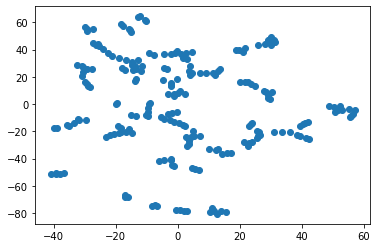

In [28]:
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
import ast


tweets = []
for tweet in data.iterrows():
    tweets.append(ast.literal_eval(tweet[1]['Clean_text']))
model = Word2Vec(tweets, workers=4, min_count=50, window=10, sample=1e-3)
vectors = model.wv[model.wv.key_to_index]
plot = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(vectors)
plt.scatter(plot[:,0], plot[:,1])
plt.show()

d:\Program Files\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


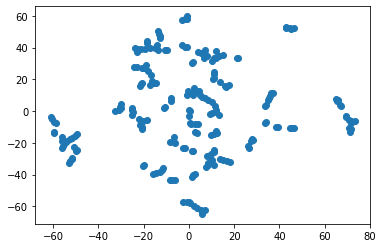

In [53]:
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
import ast


tweets = []
for tweet in data.iterrows():
    tweets.append(ast.literal_eval(tweet[1]['Clean_text']))
model = Word2Vec(tweets, workers=4, min_count=50, window=10, sample=1e-3)
vectors = model.wv[model.wv.key_to_index]
plot = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=3).fit_transform(vectors)
plt.scatter(plot[:,0], plot[:,1])
plt.show()